In [18]:
"""
Create Train and Test Files for the SemEval 2010 Task 8 experiment
"""
def createFile(filepath, outputpath):
    fOut = open(outputpath, 'w')
    lines = [line.strip() for line in open(filepath)]
    for idx in xrange(0, len(lines), 4):
        sentence = lines[idx].split("\t")[1][1:-1]
        label = lines[idx+1]
        
        sentence = sentence.replace("<e1>", " _e1_ ").replace("</e1>", " _/e1_ ")
        sentence = sentence.replace("<e2>", " _e2_ ").replace("</e2>", " _/e2_ ")
        tokens = nltk.word_tokenize(sentence)
        #print tokens
        tokens.remove('_/e1_')    
        tokens.remove('_/e2_')
        
        e1 = tokens.index("_e1_")
        del tokens[e1]
        
        e2 = tokens.index("_e2_")
        del tokens[e2]
        
        #print tokens
        #print tokens[e1], "<->", tokens[e2]
    
        fOut.write("\t".join([label, str(e1), str(e2), " ".join(tokens)]))
        fOut.write("\n")
    fOut.close()

In [19]:
import nltk
trainFile = 'corpus/SemEval2010_task8_training/TRAIN_FILE.TXT'
testFile = 'corpus/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT'

createFile(trainFile, "files/train.txt")
createFile(testFile, "files/test.txt")

print "Train / Test file created"

Train / Test file created


In [20]:
def createMatrices(file, word2Idx, maxSentenceLen=100):
    """Creates matrices for the events and sentence for the given file"""
    labels = []
    positionMatrix1 = []
    positionMatrix2 = []
    tokenMatrix = []
    
    for line in open(file):
        splits = line.strip().split('\t')
        
        label = splits[0]
        pos1 = splits[1]
        pos2 = splits[2]
        sentence = splits[3]
        tokens = sentence.split(" ")
        
        labelsDistribution[label] += 1
      
        
        tokenIds = np.zeros(maxSentenceLen)
        positionValues1 = np.zeros(maxSentenceLen)
        positionValues2 = np.zeros(maxSentenceLen)
        
        for idx in xrange(0, min(maxSentenceLen, len(tokens))):
            tokenIds[idx] = getWordIdx(tokens[idx], word2Idx)
            
            distance1 = idx - int(pos1)
            distance2 = idx - int(pos2)
            
            if distance1 in distanceMapping:
                positionValues1[idx] = distanceMapping[distance1]
            elif distance1 <= minDistance:
                positionValues1[idx] = distanceMapping['LowerMin']
            else:
                positionValues1[idx] = distanceMapping['GreaterMax']
                
            if distance2 in distanceMapping:
                positionValues2[idx] = distanceMapping[distance2]
            elif distance2 <= minDistance:
                positionValues2[idx] = distanceMapping['LowerMin']
            else:
                positionValues2[idx] = distanceMapping['GreaterMax']
            
        tokenMatrix.append(tokenIds)
        positionMatrix1.append(positionValues1)
        positionMatrix2.append(positionValues2)
        
        labels.append(labelsMapping[label])
        

    
    return np.array(labels, dtype='int32'), np.array(tokenMatrix, dtype='int32'), np.array(positionMatrix1, dtype='int32'), np.array(positionMatrix2, dtype='int32'),

In [21]:
def getWordIdx(token, word2Idx): 
    """Returns from the word2Idex table the word index for a given token"""       
    if token in word2Idx:
        return word2Idx[token]
    elif token.lower() in word2Idx:
        return word2Idx[token.lower()]
    
    return word2Idx["UNKNOWN"]

In [22]:
import gensim
W2V_model = gensim.models.KeyedVectors.load_word2vec_format('/home/akshay/notebooks/Relation CNN/code/GoogleNews-vectors-negative300.bin', binary=True)
vocab = list(W2V_model.vocab.keys())

In [29]:
import numpy as np
import cPickle as pkl
from nltk import FreqDist
import gzip

outputFilePath = 'pkl/sem-relations.pkl.gz'
embeddingsPklPath = 'pkl/embeddings.pkl.gz'

#Download from https://levyomer.wordpress.com/2014/04/25/dependency-based-word-embeddings/ the deps.words.bz file
#and unzip it. Change the path here to the correct path for the embeddings file
#embeddingsPath = '/home/akshay/notebooks/Session 3 - Relation CNN/code/deps.words'
embeddingsPath = '/home/akshay/notebooks/Relation CNN/code/GoogleNews-vectors-negative300.bin'


folder = 'files/'
files = [folder+'train.txt', folder+'test.txt']

#Mapping of the labels to integers
labelsMapping = {'Other':0, 
                 'Message-Topic(e1,e2)':1, 'Message-Topic(e2,e1)':2, 
                 'Product-Producer(e1,e2)':3, 'Product-Producer(e2,e1)':4, 
                 'Instrument-Agency(e1,e2)':5, 'Instrument-Agency(e2,e1)':6, 
                 'Entity-Destination(e1,e2)':7, 'Entity-Destination(e2,e1)':8,
                 'Cause-Effect(e1,e2)':9, 'Cause-Effect(e2,e1)':10,
                 'Component-Whole(e1,e2)':11, 'Component-Whole(e2,e1)':12,  
                 'Entity-Origin(e1,e2)':13, 'Entity-Origin(e2,e1)':14,
                 'Member-Collection(e1,e2)':15, 'Member-Collection(e2,e1)':16,
                 'Content-Container(e1,e2)':17, 'Content-Container(e2,e1)':18}

words = {}
maxSentenceLen = [0,0,0]
labelsDistribution = FreqDist()

distanceMapping = {'PADDING': 0, 'LowerMin': 1, 'GreaterMax': 2}
minDistance = -30
maxDistance = 30
for dis in xrange(minDistance,maxDistance+1):
    distanceMapping[dis] = len(distanceMapping)

for fileIdx in xrange(len(files)):
    file = files[fileIdx]
    for line in open(file):
        splits = line.strip().split('\t')
        
        label = splits[0]
        
        sentence = splits[3]        
        tokens = sentence.split(" ")
        maxSentenceLen[fileIdx] = max(maxSentenceLen[fileIdx], len(tokens))
        for token in tokens:
            words[token.lower()] = True
            

print "Max Sentence Lengths: ",maxSentenceLen
        
# :: Read in word embeddings ::
word2Idx = {}
embeddings = []
for index, word in enumerate(vocab):
    if len(word2Idx) == 0: #Add padding+unknown
        word2Idx["PADDING"] = len(word2Idx)
        vector = np.zeros(300) #Zero vector vor 'PADDING' word
        embeddings.append(vector)
        
        word2Idx["UNKNOWN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, 300)
        embeddings.append(vector)

    if word.lower() in words:
        vector = np.array(W2V_model[vocab[index]])
        embeddings.append(vector)
        word2Idx[word] = len(word2Idx)
        #break
        
embeddings = np.array(embeddings)

print "Embeddings shape: ", embeddings.shape
print "Len words: ", len(words)

f = gzip.open(embeddingsPklPath, 'wb')
pkl.dump(embeddings, f, -1)
f.close()

# :: Create token matrix ::
train_set = createMatrices(files[0], word2Idx, max(maxSentenceLen))
test_set = createMatrices(files[1], word2Idx, max(maxSentenceLen))

f = gzip.open(outputFilePath, 'wb')
pkl.dump(train_set, f, -1)
pkl.dump(test_set, f, -1)
f.close()

print "Data stored in pkl folder"

for label, freq in labelsDistribution.most_common(100):
    print "%s : %f%%" % (label, 100*freq / float(labelsDistribution.N()))

Max Sentence Lengths:  [97, 67, 0]
Embeddings shape:  (54550, 300)
Len words:  23502
Data stored in pkl folder
Other : 17.392927%
Entity-Destination(e1,e2) : 10.590650%
Cause-Effect(e2,e1) : 7.959317%
Member-Collection(e2,e1) : 7.586078%
Entity-Origin(e1,e2) : 7.268825%
Message-Topic(e1,e2) : 6.531679%
Component-Whole(e1,e2) : 5.897173%
Component-Whole(e2,e1) : 5.794532%
Instrument-Agency(e2,e1) : 5.048054%
Content-Container(e1,e2) : 4.917421%
Product-Producer(e2,e1) : 4.824111%
Cause-Effect(e1,e2) : 4.460203%
Product-Producer(e1,e2) : 4.021648%
Content-Container(e2,e1) : 1.912849%
Message-Topic(e2,e1) : 1.819539%
Entity-Origin(e2,e1) : 1.819539%
Instrument-Agency(e1,e2) : 1.110385%
Member-Collection(e1,e2) : 1.026407%
Entity-Destination(e2,e1) : 0.018662%


In [30]:
def getPrecision(pred_test, yTest, targetLabel):
    #Precision for non-vague
    targetLabelCount = 0
    correctTargetLabelCount = 0
    
    for idx in xrange(len(pred_test)):
        if pred_test[idx] == targetLabel:
            targetLabelCount += 1
            
            if pred_test[idx] == yTest[idx]:
                correctTargetLabelCount += 1
    
    if correctTargetLabelCount == 0:
        return 0
    
    return float(correctTargetLabelCount) / targetLabelCount

In [31]:
import numpy as np
np.random.seed(1337)  # for reproducibility

import cPickle as pkl
import gzip
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Merge
from keras.layers.embeddings import Embedding
from keras.layers import Convolution1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

batch_size = 64
nb_filter = 100
filter_length = 3
hidden_dims = 100
nb_epoch = 100
position_dims = 50

print "Load dataset"
f = gzip.open('pkl/sem-relations.pkl.gz', 'rb')
yTrain, sentenceTrain, positionTrain1, positionTrain2 = pkl.load(f)
yTest, sentenceTest, positionTest1, positionTest2  = pkl.load(f)
f.close()

max_position = max(np.max(positionTrain1), np.max(positionTrain2))+1

n_out = max(yTrain)+1
train_y_cat = np_utils.to_categorical(yTrain, n_out)


print "sentenceTrain: ", sentenceTrain.shape
print "positionTrain1: ", positionTrain1.shape
print "yTrain: ", yTrain.shape

print "sentenceTest: ", sentenceTest.shape
print "positionTest1: ", positionTest1.shape
print "yTest: ", yTest.shape


f = gzip.open('pkl/embeddings.pkl.gz', 'rb')
embeddings = pkl.load(f)
f.close()

print "Embeddings: ",embeddings.shape

Load dataset
sentenceTrain:  (8000, 97)
positionTrain1:  (8000, 97)
yTrain:  (8000,)
sentenceTest:  (2717, 97)
positionTest1:  (2717, 97)
yTest:  (2717,)
Embeddings:  (54550, 300)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 97, 400)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 97, 100)           120100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                1919      
Total params: 16,493,419
Trainable params: 128,419
Non-trainable params: 16,365,000
_________________________________________________________________


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", padding="same", strides=1, filters=100, kernel_size=3)`


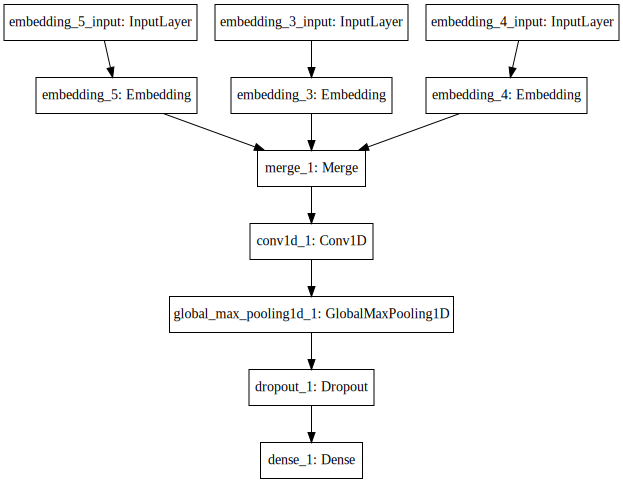

In [32]:
distanceModel1 = Sequential()
distanceModel1.add(Embedding(max_position, position_dims, input_length=positionTrain1.shape[1]))

distanceModel2 = Sequential()
distanceModel2.add(Embedding(max_position, position_dims, input_length=positionTrain2.shape[1]))

wordModel = Sequential()
wordModel.add(Embedding(embeddings.shape[0], embeddings.shape[1], input_length=sentenceTrain.shape[1], weights=[embeddings], trainable=False))


model = Sequential()
model.add(Merge([wordModel, distanceModel1, distanceModel2], mode='concat'))


model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='same',
                        activation='tanh',
                        subsample_length=1))
# we use standard max over time pooling
model.add(GlobalMaxPooling1D())

model.add(Dropout(0.25))
model.add(Dense(n_out, activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [33]:
print "Start training"
max_prec, max_rec, max_acc, max_f1 = 0,0,0,0
for epoch in xrange(nb_epoch):       
    model.fit([sentenceTrain, positionTrain1, positionTrain2], train_y_cat, batch_size=batch_size, verbose=True,nb_epoch=1)   
    pred_test = model.predict_classes([sentenceTest, positionTest1, positionTest2], verbose=False)
    
    dctLabels = np.sum(pred_test)
    totalDCTLabels = np.sum(yTest)
   
    acc =  np.sum(pred_test == yTest) / float(len(yTest))
    max_acc = max(max_acc, acc)
    print "Accuracy: %.4f (max: %.4f)" % (acc, max_acc)

    f1Sum = 0
    f1Count = 0
    for targetLabel in xrange(1, max(yTest)):        
        prec = getPrecision(pred_test, yTest, targetLabel)
        rec = getPrecision(yTest, pred_test, targetLabel)
        f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
        f1Sum += f1
        f1Count +=1    
        
        
    macroF1 = f1Sum / float(f1Count)    
    max_f1 = max(max_f1, macroF1)
    print "Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1)

Start training


/anaconda/lib/python2.7/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
8000/8000 [==============================] - 2s - loss: 2.4971 - acc: 0.2467          